In [1]:
import numpy as np
from utils.database_repository import DataRepository
from utils.objects import *
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import time
from datetime import datetime
import inspect
from utils.constants import *
from datetime import datetime
import math
import statistics
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from pathlib import Path


np.percentile(arr, 50)
statistics.median(items)

In [5]:
# for d in duts:
#             for o in os:
#                 for t in test_cases:
#                     for p in profilers:
#                         if o in special_between and p in special_between[o]:
#                             version = special_between[o][p]
#                         else:
#                             version = dut_version[d][o]
                        
#                         exp = data[d][o][t][p]
                        
#                         k = exp.k
#                         points_to_look_back = exp.points_to_look_back
                        
#                         outliers = find_outliers(exp["experiment"], k, points_to_look_back, p, 1, 0, 0, 1, False, False, min_sampels=4, show_graphs=False)
                        
#                         for e in exp["experiment"]:
#                             if e.id in outliers:
#                                 e.is_outlier = True
#                             else:
#                                 e.is_outlier = False
                        
                        

### Configuration

The configuration defines under what circumstances the experiment was executed under.

In [2]:
# CONFIGURATION
min_temp = 0
max_temp = 200

min_battery = 40
max_battery = 80

# between = 2
between = 0
duration = 1

special_between = {
    WINDOWS_OS : {
        CLAMP : 1,
        E3: 2
    }
}

language = "CSharp"

env = "PROD"

limit = 200

### Operating System

Here the different operation systems used in the experiments are defined

In [3]:
## OS
oses = [
    WINDOWS_OS,
    LINUX_OS
]

short_os = {
    WINDOWS_OS : "win",
    LINUX_OS : "lin"
}

### Test Cases

Here the different test cases executed during the experiments are defined

In [4]:
## Test cases
test_cases = [
    IDLE_CASE,
    # DINING_PHILOSOPHERS,
    BINARY_TREE,
    # REVERSE_COMPLEMENT
    FANNKUCH_REDUX,
    NBODY,
    FASTA
]

short_test_case = {
    IDLE_CASE : "idle",
    DINING_PHILOSOPHERS : "din",
    BINARY_TREE : "bin",
    REVERSE_COMPLEMENT : "rev",
    FANNKUCH_REDUX : "fann",
    NBODY : "nbody",
    FASTA : "fasta"
}

### Profilers

Here the different profilers used to measure the energy consumption of the test cases are defined

In [5]:
## Profilers
profilers = [
    # INTEL_POWER_GADGET,
    # RAPL,
    # HARDWARE_MONITOR,
    # CLAMP,
    E3
]

short_profilers = {
    INTEL_POWER_GADGET : "IPG",
    RAPL : "RA",
    HARDWARE_MONITOR : "HWM",
    E3 : "E3",
    CLAMP : "CL"
}

### DUT

Here the different Devices Under Tests (DUT) are defined

In [6]:
## DUT
duts = [
    SURFACE_4_PRO,
    # SURFACE_BOOK,
    # POWER_KOMPLETT
]

short_duts = {
    SURFACE_4_PRO : "pro",
    SURFACE_BOOK : "book",
    POWER_KOMPLETT : "pow",
}

dut_version = {
    SURFACE_BOOK : {
            WINDOWS_OS : 6,
            LINUX_OS : 3
        },
    SURFACE_4_PRO : {
        WINDOWS_OS : 12,
        LINUX_OS : 2,
    },
    POWER_KOMPLETT : {
        WINDOWS_OS : 8,
        LINUX_OS : 1,
    }
    #     POWER_KOMPLETT : {
    #     WINDOWS_OS : 9,
    #     LINUX_OS : -1,
    # }
}

In [7]:
repository = DataRepository()

data = repository.get_experiments(
        duts,
        oses,
        test_cases,
        profilers,
        dut_version,
        min_temp,
        max_temp,
        min_battery,
        max_battery,
        duration,
        between,
        env,
        language,
        special_between
    )

repository.close()


Connected to MySQL Server version  5.7.40-43-log
success for Surface4Pro, Win32NT, TestCaseIdle, E3
success for Surface4Pro, Win32NT, BinaryTrees, E3
success for Surface4Pro, Win32NT, FannkuchRedux, E3
success for Surface4Pro, Win32NT, Nbody, E3
success for Surface4Pro, Win32NT, Fasta, E3


In [14]:
e3_exp = data[SURFACE_4_PRO][WINDOWS_OS][IDLE_CASE][E3]["experiment"].experiments[0].TotalEnergyConsumption
# inspect.getmembers(e3_exp, lambda a:not(inspect.isroutine(a)))
e3_exp / 1000

0.479

In [438]:
data[POWER_KOMPLETT][WINDOWS_OS][FASTA][CLAMP]

{'contains_data': True,
 'config': <utils.objects.Configuration at 0x1e32aa6bc40>,
 'profiler': <utils.objects.EnergyProfiler at 0x1e3290ea0e0>,
 'dut': <utils.objects.Dut at 0x1e32aaae0e0>,
 'test_case': <utils.objects.TestCase at 0x1e32aaae1d0>,
 'experiment': <utils.objects.Experiment at 0x1e32aaad810>}

In [439]:
# exp_two_data = data
# %store exp_two_data

Stored 'exp_two_data' (dict)


In [ ]:
# %store data

In [123]:

# %store -r

{'TestCaseIdle': {'IntelPowerGadget': {'contains_data': False},
  'RAPL': {'contains_data': True,
   'config': <utils.objects.Configuration at 0x1e54174ec80>,
   'profiler': <utils.objects.EnergyProfiler at 0x1e54174ecb0>,
   'dut': <utils.objects.Dut at 0x1e54174ed10>,
   'test_case': <utils.objects.TestCase at 0x1e54174ed70>,
   'experiment': <utils.objects.Experiment at 0x1e54174edd0>},
  'HardwareMonitor': {'contains_data': False},
  'Clamp': {'contains_data': True,
   'config': <utils.objects.Configuration at 0x1e549fd5690>,
   'profiler': <utils.objects.EnergyProfiler at 0x1e549fd56c0>,
   'dut': <utils.objects.Dut at 0x1e549fd5720>,
   'test_case': <utils.objects.TestCase at 0x1e549fd5780>,
   'experiment': <utils.objects.Experiment at 0x1e549fd57e0>},
  'E3': {'contains_data': False}},
 'BinaryTrees': {'IntelPowerGadget': {'contains_data': False},
  'RAPL': {'contains_data': True,
   'config': <utils.objects.Configuration at 0x1e54d9781c0>,
   'profiler': <utils.objects.EnergyP

In [440]:
# exp_one_data = data


# current_exp_name = "exp_one"
# data = exp_one_data

current_exp_name = "exp_two"
data = exp_two_data


In [337]:
# %store exp_one_data

### Types

Here the different types of energy measurements are defined

In [441]:
## Types
comparison_types = [PACKAGE_TOTAL, DRAM_TOTAL,CORE_TOTAL]


In [442]:
def find_outliers(experiments, k, points_to_look_back, profiler, y_max, y_min, x_min, x_max, use_x_lim, use_y_lim, min_sampels=4, show_graphs=False):
    exp_data_points = []
    # k = 1

    for e in experiments:
        if profiler == INTEL_POWER_GADGET:
            power = e.CumulativeProcessorEnergyInJoules
        elif profiler == HARDWARE_MONITOR:
            power = e.cpuPowerPacketTotalJ
        elif profiler == RAPL:
            power = e.CoreStopInJoules - e.CoreStartInJoules
        elif profiler == CLAMP:
            power = e.TrueRMS
        elif profiler == E3:
            power = e.TotalEnergyConsumption
        else:
            raise Exception("profiler not implemented") ## ipg CumulativeProcessorEnergyInJoules, TrueRMS, x.CoreStopInJoules - x.CoreStartInJoules
        
        exp_data_points.append(ExpDataPoint(
            e.id, power, e.runs, e.duration
        ))
    
    # if show_graphs:
    #     plt.scatter(*zip(*(x.get_tuple() for x in exp_data_points)))
    #     plt.show()
    
    for p1 in exp_data_points:
        dists = []
        for p2 in exp_data_points:
            if p1.exp_id == p2.exp_id:
                dists.append(math.inf)
            else:
                dists.append(math.dist(p1.get_tuple(), p2.get_tuple()))
        sorted_by_second = sorted(dists, key=lambda tup: tup)
        p1.set_distance_to_k(sorted_by_second[k])
    
    exp_data_points = sorted(exp_data_points, key=lambda tup: tup.dist)
    
    for i in range(len(exp_data_points)):
        exp_data_points[i].set_id(i)

    if show_graphs:
        plt.scatter(*zip(*((x.id, x.dist) for x in exp_data_points)))

        plt.show()
    
    eps = exp_data_points[-points_to_look_back].dist
    print(eps)
    min_sampels = 4
    
    data_arr = np.array([x.get_tuple() for x in exp_data_points])
    
    dbscan = DBSCAN(eps = eps, min_samples = min_sampels)
    pred = dbscan.fit_predict(data_arr)
    anom_index = np.where(pred == -1)
    values = data_arr[anom_index]

    if show_graphs:
        plt.scatter(data_arr[:,0], data_arr[:,1])
        plt.scatter(values[:,0], values[:,1], color='r')
        if use_x_lim:
            plt.xlim(x_min, x_max)
        if use_y_lim:
            plt.ylim(y_min,y_max)
        plt.show()

    points_to_remove = []

    for v in values:
        for e in exp_data_points:
            tup = (v[0], v[1])
            
            if tup == e.get_tuple():
                points_to_remove.append(e)
                break

    print(f"{len(points_to_remove)} points were removed")
                
    # for p in points_to_remove:
    #     print(f"{p.exp_id} - {p.get_tuple()}")
    
    
    
    return [x.exp_id for x in points_to_remove], ((x.id, x.dist) for x in exp_data_points), data_arr[:,0], data_arr[:,1], values[:,0], values[:,1]
    

In [443]:
# def get_dynamic_energy(
#     d, o, p, energy_type, duration, energy_consumption, dynamic_energy, per_unit=1000
# ):
#     dynamic_energy_index = dynamic_energy[d][o][p]

#     dynamic_energy_consumption = dynamic_energy_index[energy_type]
#     dynamic_duration = dynamic_energy_index["duration"]

#     if dynamic_duration == 0 or duration == 0:
#         return 0

#     dynamic_energy_per_unit = (per_unit / dynamic_duration) * dynamic_energy_consumption
#     energy_per_unit = (per_unit / duration) * energy_consumption

#     return energy_per_unit - dynamic_energy_per_unit

In [444]:
def default_func(exp, value):
    return True


def get_consumption(
    d,
    o,
    p,
    t,
    value_type,
    func_parameter,
    data,
    dynamic_energy,
    func=default_func,
    get_dynamic=True,
    include_outliers = False
):
    try:
        data_points = data[d][o][t][p]["experiment"].experiments
    except Exception as e:
        return 0, 0, 0, 0, 0, 0, 0, 0,0, 0, 0, 0
    
    if not include_outliers:
        data_points = [x for x in data_points if not x.is_outlier]

    # duration = [
    #     exp.duration / exp.runs for exp in data_points if func(exp, func_parameter)
    # ]

    duration_list = [x.duration for x in data_points if func(x, func_parameter)]
    runs_list = [x.runs for x in data_points if func(x, func_parameter)]

    if len(duration_list) > 0:
        avg_dur = sum(duration_list) / len(duration_list)
    else:
        avg_dur = 0
    
    if len(runs_list) > 0:
        avg_run = sum(runs_list) / len(runs_list)
    else:
        avg_run = 0

    length = len(duration_list)

    if value_type == PACKAGE_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeProcessorEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [(x.TrueRMS, x.duration) for x in data_points]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerPacketTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == RAPL:
            values = [
                (x.PSysStopInJoules - x.PSysStartInJoules, x.duration) for x in data_points if func(x, func_parameter)
            ]
        elif p == E3:
            values = [x for x in data_points if func(x, func_parameter)]
        else:
            raise Exception(f"{p} not implemented")
    elif value_type == DRAM_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeDramEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [(0, 0) for x in data_points]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerMemoryTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == RAPL:
            values = [
                (x.DramStopInJoules - x.DramStartInJoules, x.duration) for x in data_points if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    elif value_type == CORE_TOTAL:
        if p == INTEL_POWER_GADGET:
            values = [
                (x.CumulativeProcessorEnergyInJoules, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == CLAMP:
            values = [
                (x.TrueRMS, x.duration) for x in data_points if func(x, func_parameter)
            ]
        elif p == HARDWARE_MONITOR:
            values = [
                (x.cpuPowerCoresTotalJ, x.duration)
                for x in data_points
                if func(x, func_parameter)
            ]
        elif p == RAPL:
            values = [
                (x.CoreStopInJoules - x.CoreStartInJoules, x.duration) for x in data_points if func(x, func_parameter)
            ]
        else:
            raise Exception(f"{p} not implemented")
    else:
        raise Exception(f"{value_type} not implmeneted")

    if get_dynamic:
        if length == 0:
            return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        
        only_values = [x[0] / avg_run for x in values]
        avg_value = sum(only_values) / len(only_values)
        
        dyn_val = []
        
        for v in only_values:
            dyn = get_dynamic_energy(d, o, p, value_type, v, dynamic_energy, avg_run, avg_dur)
            dyn_val.append(dyn)

        return (
            length,
            sum(dyn_val) / len(dyn_val),
            np.std(dyn_val),
            min(dyn_val),
            max(dyn_val),
            avg_dur,
            avg_run,
            0,
            np.percentile(dyn_val, 25),
            np.percentile(dyn_val, 75),
            statistics.median(dyn_val),
            dyn_val
        )
    else:
        only_values = [x[0] / avg_run for x in values]
        
        avg_value = sum(only_values) / len(only_values)
        
        # value_for_one_sec = avg_value * (1000 / (avg_dur / avg_run))
        
        values_for_one_sec = [x * (1000 / (avg_dur / avg_run)) for x in only_values]
        
        value_for_one_sec = sum(values_for_one_sec) / len(values_for_one_sec)
        
        return (
            length,
            avg_value,
            np.std(values_for_one_sec),
            min(values_for_one_sec),
            max(values_for_one_sec),
            avg_dur,
            avg_run,
            value_for_one_sec,
            np.percentile(values_for_one_sec, 25),
            np.percentile(values_for_one_sec, 75),
            statistics.median(values_for_one_sec),
            only_values
        )

In [445]:
def initialize_dynamic_energy(data, used_profilers = profilers):
    dynamic_energy = {}
    for d in duts:
        dynamic_energy[d] = {}
        for o in oses:
            dynamic_energy[d][o] = {}
            for p in used_profilers:
                dynamic_energy[d][o][p] = {}
                for types in comparison_types:
                    t = IDLE_CASE
                    
                    count, average, _, min_value, max_value, avg_dur, avg_run, _, _, _, _, _ = get_consumption(
                        d, o, p, t, types, "", data, dynamic_energy, get_dynamic=False)
                    dynamic_energy[d][o][p][types] = average
                    dynamic_energy[d][o][p]["avg_dur"] = avg_dur
                    dynamic_energy[d][o][p]["avg_run"] = avg_run
    return dynamic_energy

In [446]:
def is_correct_first_profiler(exp, value):
    return exp.first_profiler == value

def plot_first_profiler_comparison(comparison_type, data, dynamic_energy, xlabel, ylabel, label, ylim_max=100):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    x = []
    y = []
    e = []

    i = 0

    for d in duts:
        for t in test_cases:
            if t != IDLE_CASE:
                for o in oses:
                    for p in profilers:
                        for first_profiler in profilers:
                            length, average, std, min_value, max_value, _, _, _, _, _, _, _ = get_consumption(d, o, p, t, comparison_type, first_profiler, data, dynamic_energy, func=is_correct_first_profiler)
                            
                            if length > 0:
                                x.append(f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                y.append(average)
                                e.append(std)
                                
                                # print(f"{i} - {first_profiler}, {p}, {d}, {o}, {t} - sum of {length} ({min_value} - {max_value})")
                                # print(f"{i} - {d}, {t}, {o}, {p}, {first_profiler} - sum of {length} ({min_value} - {max_value})")
                                i += 1

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(label)
    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation = 90)
    plt.errorbar(x, y, e, linestyle='None', marker='.')
    plt.ylim(0,ylim_max)
    plt.show()

In [447]:
def plot_comparison(comparison_type, data, dynamic_energy, xlabel, ylabel, label, ylim_max=100, get_dynamic=True, used_test_cases = test_cases, include_idle = False, plot_graph=True, used_profilers=profilers, include_outliers=False, funcs=[(default_func, "")], used_duts = duts, used_osses = oses):
    
    if plot_graph:
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])

    x = []
    y = []
    e = []
    
    perc25 = []
    perc75 = []
    low_whiskey = []
    high_whiskey = []
    median = []
    names = []
    all_values = []
    other_names = []
    other_other_names = []


    i = 0

    for (f, desc) in funcs:
        for t in used_test_cases:
            if include_idle or t != IDLE_CASE:
                for d in used_duts:
                    for o in used_osses:
                        for p in used_profilers:
                            if (p == CLAMP and d == POWER_KOMPLETT) or p != CLAMP:
                                length, average, std, min_value, max_value, _, _, val_for_one_sec, p25, p75, m, values = get_consumption(d, o, p, t, comparison_type, "", data, dynamic_energy, get_dynamic=get_dynamic, include_outliers=include_outliers, func=f)
                                
                                if length > 0:
                                    if plot_graph:
                                        x.append(f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]} {desc}")
                                        e.append(std)
                                        if get_dynamic:
                                            y.append(average)
                                        else:
                                            y.append(val_for_one_sec)
                                    
                                    perc25.append(p25)
                                    perc75.append(p75)
                                    low_whiskey.append(min_value)
                                    high_whiskey.append(max_value)
                                    median.append(m)
                                    all_values.append(values)
                                    
                                    used_dut_name = "workstation" if d == POWER_KOMPLETT else d
                                    
                                    
                                    if p == CLAMP:
                                        names.append(f"{used_dut_name} - {p} ({short_os[o]}) {desc}")
                                        other_names.append(f"{t} - {used_dut_name} - {p} ({short_os[o]}) {desc}")
                                        other_other_names.append(f"{t} - {desc} ({short_os[o]})")
                                    else:
                                        names.append(f"{used_dut_name} - {p} {desc}")
                                        other_names.append(f"{t} - {used_dut_name} - {p} {desc}")
                                        other_other_names.append(f"{t} - {desc}")
                                    # names.append(f"{}")
                                    # names.append(f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                    
                                    i += 1
                                # else:
                                #     print(f"nothing found for {short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]} {desc}")

    if plot_graph:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(label)
        plt.errorbar(x, y, e, linestyle='None', marker='.')
        ax.tick_params(axis='x', labelrotation = 90)
        plt.ylim(0,ylim_max)
        
        plt.show()
    
    return perc25, perc75, low_whiskey, high_whiskey, median, names, all_values, other_names, other_other_names

In [448]:
def plot_iterations(comparison_type, get_next_value, is_correct_value, xlabel, ylabel, label, data, dynamic_energy, used_duts = duts, used_test_cases = test_cases, plot_graph=True, get_dynamic=True, include_outliers=False):
    if plot_graph:
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
    
    x_lines = []
    y_lines = []
    name_lines = []
    
    print(used_test_cases)
    for d in used_duts:
        for t in used_test_cases:
            if t != IDLE_CASE:
                for o in oses:
                    for p in profilers:
                        if (p == CLAMP and d == POWER_KOMPLETT) or p != CLAMP:
                            x1 = []
                            y1 = []
                            avg_len = []
                            for i in get_next_value():
                                length, average, _, min_value, max_value, _, _, _, _, _, _, _ = get_consumption(d, o, p, t, comparison_type, i, data, dynamic_energy, func=is_correct_value, get_dynamic=get_dynamic, include_outliers=include_outliers)
                                
                                if length > 0:
                                    avg_len.append(length)
                                    if isinstance(i, tuple) or isinstance(i, list):
                                        x1.append(i[0])
                                    else:
                                        x1.append(i)
                                    y1.append(average)
                            if len(x1) > 0:
                                print(f"{d} - {t} - {o} - {p} - avg {sum(avg_len) / len(avg_len)} ({min(avg_len)}, {max(avg_len)})")
                                if plot_graph:
                                    plt.plot(x1, y1, label = f"{short_os[o]} {short_duts[d]} {short_profilers[p]} {short_test_case[t]}")
                                x_lines.append(x1)
                                y_lines.append(y1)
                                
                                used_dut_name = "workstation" if d == POWER_KOMPLETT else d
                                if p == CLAMP:
                                    name_lines.append(f"{used_dut_name} - {p} ({short_os[o]})")
                                else:
                                    name_lines.append(f"{used_dut_name} - {p}")
                                
    if plot_graph:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(label)
        plt.legend()
        plt.show()
    return x_lines, y_lines, name_lines

### Datainitialization

The data for the experiments will be fetched from the database and stored in a dictionary, in the order as can be seen below:

```python
data[current_dut][current_os][current_test_case][current_profiler]
```

In [449]:
# exp = data[SURFACE_4_PRO][LINUX_OS][BINARY_TREE][RAPL]["experiment"].experiments[0]
# inspect.getmembers(exp, lambda a:not(inspect.isroutine(a)))

In [450]:
data[POWER_KOMPLETT][WINDOWS_OS][IDLE_CASE][INTEL_POWER_GADGET]["contains_data"]
# ee.k, ee.look_back

True

In [451]:
class ExpDataPoint(object):
    def __init__(self, exp_id, consumption, runs, duration):
        self.exp_id = exp_id
        self.x = consumption/ runs
        self.y = duration / runs
    
    def set_id(self, id):
        self.id = id
    
    def get_tuple(self):
        return (self.x, self.y)

    def set_distance_to_k(self, value):
        self.dist = value

In [452]:
for d in duts:
    if d in data:
        for o in oses:
            for t in test_cases:
                for p in profilers:
                    if data[d][o][t][p]["contains_data"]:
                        ee = data[d][o][t][p]["experiment"]
                        removed_points, _, _, _, _, _ = find_outliers(ee.experiments, ee.k, ee.look_back, p, 0, 0, 0, 0, False, False, min_sampels=4, show_graphs=False)
                        
                        for e in ee.experiments:
                            # if any([x == e.id for x in removed_points]):
                            if e.id in removed_points:
                                e.is_outlier = True
                            else:
                                e.is_outlier = False




10.868000000000052
2 points were removed
3.0586068997077125
2 points were removed
45.88319167674808
3 points were removed
0.005400833396201998
0 points were removed
0.0057958431849398665
2 points were removed
0.010906163523040552
2 points were removed
0.027373144117763475
1 points were removed
0.009741236945624895
0 points were removed
0.014128678608724495
0 points were removed
0.002769849022800402
1 points were removed
0.00040819364973590885
1 points were removed
0.0013725235258148169
2 points were removed
0.0006192352599404448
1 points were removed
0.0002766323180615926
3 points were removed
0.0005902742062531486
8 points were removed


In [453]:
ee.experiments[0].id, ee.experiments[0].is_outlier 

(12584, False)

### Dynamic Energy

Next up, the dynamic energy will be calculated. This will be the average energy consumption of the idle case.

In [454]:
dynamic_energy = initialize_dynamic_energy(data)
dynamic_energy.keys()

dict_keys(['PowerKomplett'])

### Dynamic Energy Example

An example of how the dynamic energy consumption is calculated can be seen below.

In [455]:
def get_dynamic_energy(d, o, p, energy_type, energy_consumption, dynamic_energy, avg_run, avg_dur, per_unit=1000):
    dynamic_energy_index = dynamic_energy[d][o][p]

    dynamic_energy_consumption = dynamic_energy_index[energy_type]
    dyn_avg_dur = dynamic_energy_index["avg_dur"]
    dyn_avg_run = dynamic_energy_index["avg_run"]
    
    if dyn_avg_dur == 0 or dyn_avg_run == 0:
        return 0
    
    dynamic_energy_per_unit = dynamic_energy_consumption * (per_unit / (dyn_avg_dur / dyn_avg_run))
    energy_per_unit = energy_consumption * (per_unit / (avg_dur / avg_run))
    
    return energy_per_unit - dynamic_energy_per_unit 

In [456]:
dynamic_energy_dut = POWER_KOMPLETT
dynamic_energy_os = WINDOWS_OS
dynamic_energy_profiler = INTEL_POWER_GADGET
dynamic_energy_test_case = NBODY
dynamic_energy_type = CORE_TOTAL

In [457]:
length, energy_consumption, _, _, _, avg_dur, avg_run, energy_consumption_per_sec, perc25, perc75, _, _ = get_consumption(dynamic_energy_dut, 
                                                            dynamic_energy_os, 
                                                            dynamic_energy_profiler, 
                                                            dynamic_energy_test_case, 
                                                            dynamic_energy_type, "", 
                                                            data,
                                                            dynamic_energy, 
                                                            get_dynamic=False,
                                                            include_outliers=False)

dynamic_energy_consumption = get_dynamic_energy(dynamic_energy_dut, 
                                                dynamic_energy_os, 
                                                dynamic_energy_profiler, 
                                                dynamic_energy_type, 
                                                energy_consumption,
                                                dynamic_energy, 
                                                avg_run, 
                                                avg_dur,
                                                per_unit=avg_dur/avg_run)
# dynamic_energy_consumption = get_dynamic_energy(d, v, o, p, dynamic_energy_type, duration, energy_consumption, per_unit=0.5716669904816651)



# energy_consumption, energy_consumption_per_sec, dynamic_energy_consumption, avg_dur/avg_run
length

14

In [458]:
# data_to_inspect = data[power_komplett][windows_os][idle_case][intel_power_gadget]["experiment"].experiments[0].start_battery.data
# inspect.getmembers(data_to_inspect, lambda a:not(inspect.isroutine(a)))

### Intel Power Gadget

- CumulativeDramEnergyInJoules
- CumulativeGtEnergyInJoules
- CumulativeIaEnergyInJoules
- CumulativeProcessorEnergyInJoules

### Clamp

- TrueRMS
- ACRMSRAW

idle -  true: 3651, acr: 3612
fans - 600 - 700

### OpenHardwareMonitor

- cpuPowerPacketTotalJ
- cpuPowerCoresTotalJ
- cpuPowerMemoryTotalJ
- cpuPowerPacketAverageJ
- cpuPowerCoresAverageJ
- cpuPowerMemoryAverageJ

### Dynamic energy consumption

A graph comparing the package measuring made by different measuring instruments on the different DUTs

In [459]:
# plot_comparison(PACKAGE_TOTAL, data, dynamic_energy, "Package total DUT", "joules in a second", "average package energy consumption in joules for DUTs")


### Dynamic energy consumption

A graph comparing the dram measuring made by different measuring instruments on the different DUTs

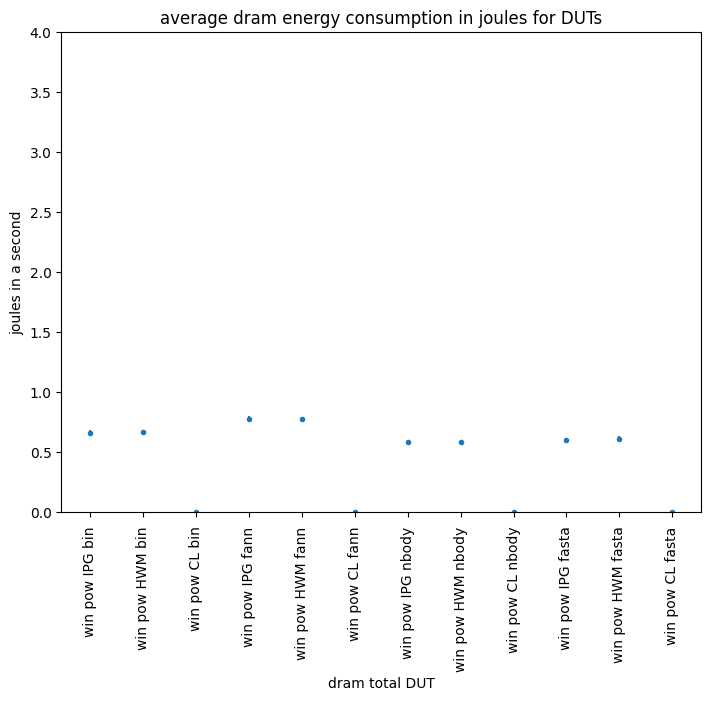

([0.648115782815673,
  0.6511916810028993,
  0.0,
  0.7698829961516469,
  0.7686623461428851,
  0.0,
  0.5801159095827022,
  0.5786980535077395,
  0.0,
  0.5967064118530172,
  0.5955342557761306,
  0.0],
 [0.6601759046572789,
  0.6737694243016865,
  0.0,
  0.7771924848330656,
  0.7750232566168644,
  0.0,
  0.5863289528438503,
  0.5820649904324364,
  0.0,
  0.6003373752695925,
  0.6061869678997145,
  0.0],
 [0.6406395352708147,
  0.6374286984504642,
  0.0,
  0.7648208892941595,
  0.7633415640722911,
  0.0,
  0.5798273881851624,
  0.578384399096336,
  0.0,
  0.596504213081308,
  0.5925673558604723,
  0.0],
 [0.7463249109490996,
  0.7193867564910849,
  0.0,
  0.8295321439143828,
  0.8124074884326415,
  0.0,
  0.6220105864141019,
  0.5867513120652417,
  0.0,
  0.6073928418713385,
  0.6556825638030647,
  0.0],
 [0.6547752088951031,
  0.6576052753632173,
  0.0,
  0.7747236532844155,
  0.7713517612576667,
  0.0,
  0.5804404930339399,
  0.5792691239911968,
  0.0,
  0.5987617879403604,
  0.6022

In [460]:
plot_comparison(DRAM_TOTAL,
                data,
                dynamic_energy,
                "dram total DUT",
                "joules in a second",
                "average dram energy consumption in joules for DUTs",
                get_dynamic=False,
                ylim_max=4)

### Dynamic energy consumption

A graph comparing the core measuring made by different measuring instruments on the different DUTs

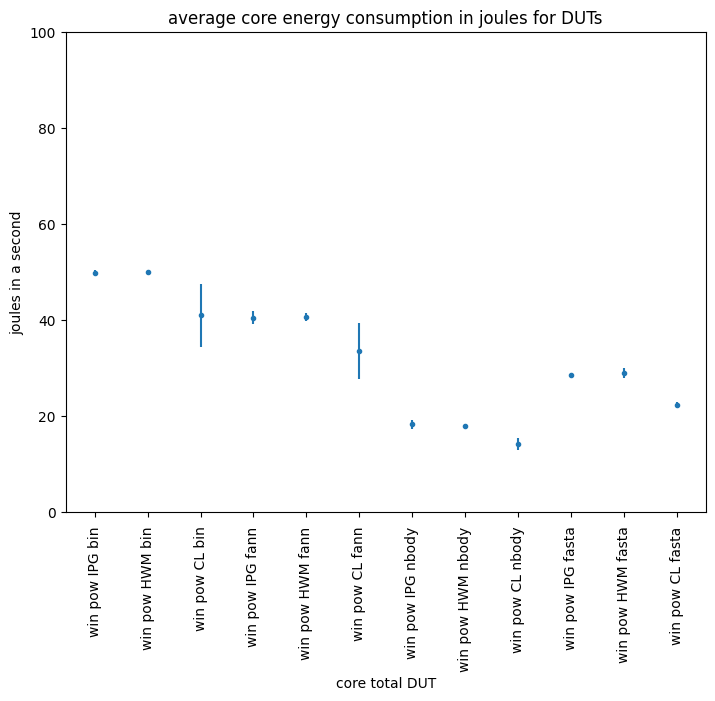

(11.847377669769841, 51.33319700734803)

In [461]:
perc25, perc75, low_whiskey, high_whiskey, median, names, all_values, other_names, _ = plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=100, get_dynamic=True, include_outliers=False)
min(low_whiskey), max(high_whiskey)

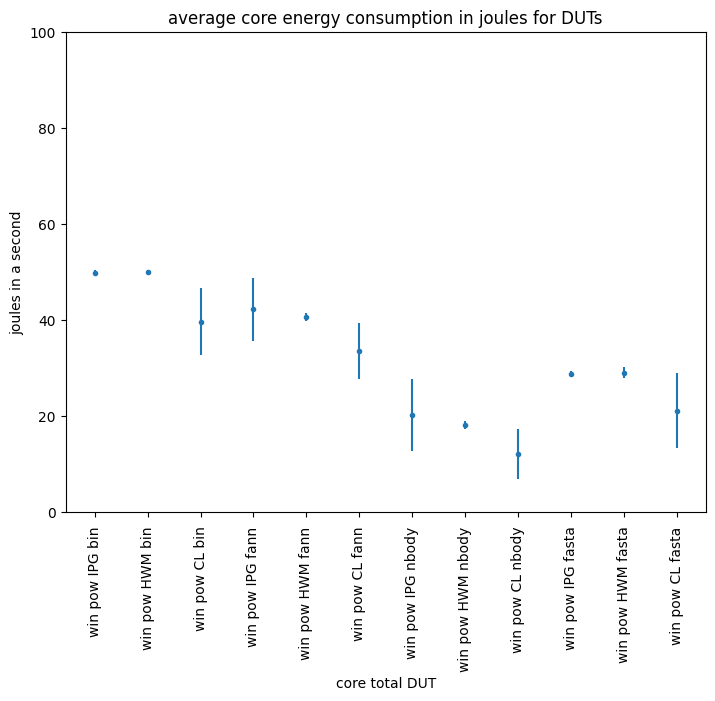

(-1.5329426235989843, 66.12230684434647)

In [462]:
perc25, perc75, low_whiskey, high_whiskey, median, names, all_values, other_names, _ = plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=100, get_dynamic=True, include_outliers=True)
min(low_whiskey), max(high_whiskey)

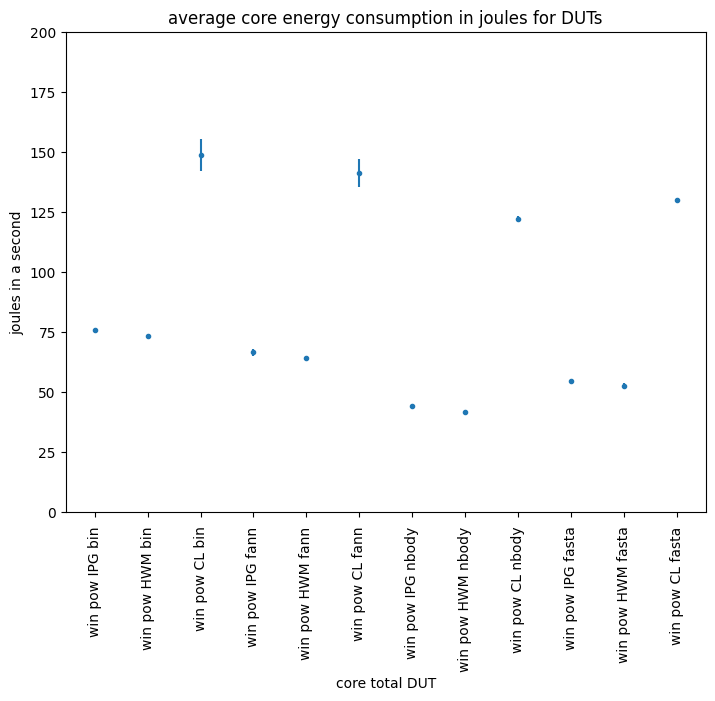

([75.50299360830921,
  73.3344629883012,
  139.89609581708925,
  65.57920896546231,
  63.72192846528614,
  142.71378294266566,
  43.778560430780495,
  41.21779803288267,
  121.12585179307337,
  54.45751347572185,
  51.933860038023106,
  129.9512460855855],
 [76.25389826558808,
  73.74863742655862,
  153.2063277790902,
  67.42512390936577,
  64.75161124104956,
  144.0241411337106,
  44.10960725402401,
  41.972430561224854,
  123.04118103943803,
  54.72020125409266,
  52.479201309170854,
  130.38603418686554],
 [75.2711092246746,
  72.5921527687717,
  137.66520831992503,
  65.12321269136255,
  62.785452723828755,
  126.07673407348872,
  43.41918038517236,
  40.984672526887394,
  119.6819741173511,
  54.22445449466433,
  51.45082608392138,
  129.0635902071594],
 [76.74686740570593,
  74.92235177564524,
  154.77867517986473,
  69.82822458594835,
  65.76229499955666,
  146.06864040481315,
  46.78936032092149,
  42.26655902756065,
  123.8566223045096,
  55.103791721157386,
  54.9510392061470

In [463]:
plot_comparison(CORE_TOTAL, data, dynamic_energy, "core total DUT", "joules in a second", "average core energy consumption in joules for DUTs", ylim_max=200, get_dynamic=False, include_idle=False)


In [464]:
# dynamic_energy_dut = SURFACE_4_PRO
# dynamic_energy_os = WINDOWS_OS
# dynamic_energy_profiler = INTEL_POWER_GADGET
# dynamic_energy_test_case = NBODY
# dynamic_energy_type = CORE_TOTAL

d = [x.cpuPowerCoresTotalJ for x in data[POWER_KOMPLETT][WINDOWS_OS][IDLE_CASE][HARDWARE_MONITOR]["experiment"].experiments]
dd = [x.cpuPowerCoresTotalJ for x in data[POWER_KOMPLETT][WINDOWS_OS][NBODY][HARDWARE_MONITOR]["experiment"].experiments]
# d = [x.CumulativeProcessorEnergyInJoules for x in data[POWER_KOMPLETT][LINUX_OS][FASTA][CLAMP]["experiment"].experiments] ACRMSRAW, cpuPowerCoresTotalJ

In [465]:
idle_per_sec = (sum(d) / len(d)) / 60
test_per_sec = (sum(dd) / len(dd)) / 60
# min(d) / 60, max(d) / 60, (sum(d) / len(d)) / 60, len(d)
idle_per_sec, test_per_sec, test_per_sec - idle_per_sec

(23.637590392430624, 41.80174895604452, 18.164158563613896)

In [466]:
data[POWER_KOMPLETT][WINDOWS_OS][IDLE_CASE]

{'IntelPowerGadget': {'contains_data': True,
  'config': <utils.objects.Configuration at 0x1e3e1126ad0>,
  'profiler': <utils.objects.EnergyProfiler at 0x1e3e1124820>,
  'dut': <utils.objects.Dut at 0x1e3e1126c20>,
  'test_case': <utils.objects.TestCase at 0x1e3e1124940>,
  'experiment': <utils.objects.Experiment at 0x1e3d54202e0>},
 'RAPL': {'contains_data': False},
 'HardwareMonitor': {'contains_data': True,
  'config': <utils.objects.Configuration at 0x1e3aeaa63e0>,
  'profiler': <utils.objects.EnergyProfiler at 0x1e39f1cb010>,
  'dut': <utils.objects.Dut at 0x1e3d54209d0>,
  'test_case': <utils.objects.TestCase at 0x1e3a0df3340>,
  'experiment': <utils.objects.Experiment at 0x1e3a0df3700>},
 'Clamp': {'contains_data': True,
  'config': <utils.objects.Configuration at 0x1e37263e740>,
  'profiler': <utils.objects.EnergyProfiler at 0x1e3a0df3880>,
  'dut': <utils.objects.Dut at 0x1e3726f9600>,
  'test_case': <utils.objects.TestCase at 0x1e3726f94e0>,
  'experiment': <utils.objects.Exp

In [467]:
count,avg_value,std, min_value, max_value, avg_dur, avg_run, value_for_one_sec, perc25, prec75, med, _ = get_consumption(
                                                            POWER_KOMPLETT,
                                                            WINDOWS_OS,
                                                            INTEL_POWER_GADGET,
                                                            FASTA,
                                                            CORE_TOTAL,
                                                            "",
                                                            data,
                                                            dynamic_energy,
                                                            get_dynamic=True,
                                                        )

count,avg_value,std, min_value, max_value, avg_dur, avg_run, value_for_one_sec , perc25, prec75, med


(16,
 28.589572488295783,
 0.21428817614636414,
 28.233300724523804,
 29.11263795101686,
 60073.3125,
 198942.6875,
 0,
 28.466359705581326,
 28.729047483952137,
 28.555091702838848)

In [468]:
sec_mult = 1000 / (avg_dur / avg_run) 
sec_mult

3311.665017639905

In [469]:
avg_value * sec_mult

94679.08707876939

In [470]:
get_consumption(
    SURFACE_BOOK,
    WINDOWS_OS,
    INTEL_POWER_GADGET,
    IDLE_CASE,
    CORE_TOTAL,
    "",
    data,
    dynamic_energy,
    get_dynamic=False,
)

print("")

### How R3 validation affects the energy consumtion

A graph presenting the the effect of which profiler was the first one to execute upon startup

In [471]:
def get_iteration():
    for i in range(30):
        yield i
        
def is_correct_iteration(exp, value):
    return exp.iteration == value

### How time passed since a restart effects energy consumptionn

A graph presenting the relationship between the iteration since a system restart, and how it affects the energy consumption

['Fasta']
PowerKomplett - Fasta - Win32NT - IntelPowerGadget - avg 3.2 (3, 4)
PowerKomplett - Fasta - Win32NT - HardwareMonitor - avg 39.4 (37, 41)
PowerKomplett - Fasta - Win32NT - Clamp - avg 2.0 (1, 3)


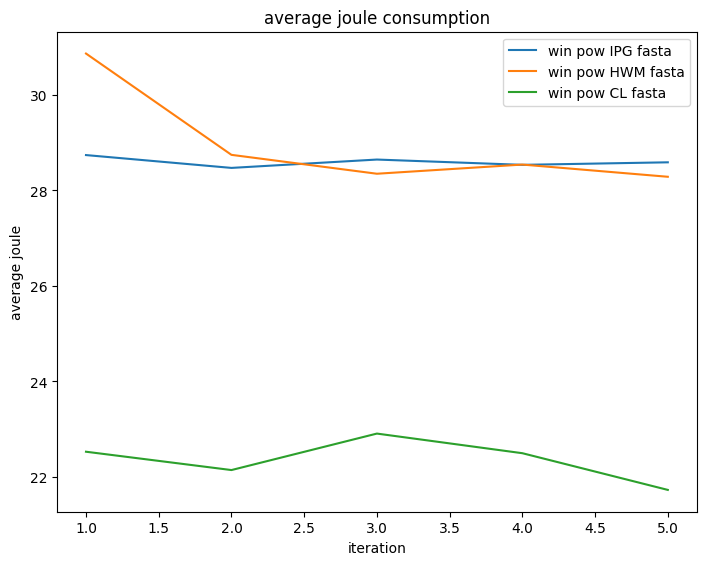

['Fasta']


In [472]:
used_duts = [POWER_KOMPLETT]
used_test_cases = [FASTA]

plot_iterations(CORE_TOTAL,
                get_iteration,
                is_correct_iteration,
                "iteration",
                "average joule",
                "average joule consumption",
                data,
                dynamic_energy,
                used_duts=used_duts,
                used_test_cases = used_test_cases,
                get_dynamic=True)

print(used_test_cases)

In [473]:
def get_buckets():
    min_bucket = 0
    max_bucket = 100
    bucket_size = 5

    last_value = 0

    for i in range(min_bucket + bucket_size, max_bucket + 1, bucket_size):
        # print(f"min: {last_value}, max: {i}, between: {((i - last_value) / 2) + last_value}")
        yield (last_value, i)
        last_value = i

def is_correct_temperature(exp, value):
    min_value = value[0]
    max_value = value[1]
    
    temp = [x.value for x in exp.start_temperature.data]
    
    avg_temp = sum(temp) / len(temp)
    
    return avg_temp > min_value and avg_temp < max_value

### Temperatures levels effect on energy consumption

A graph presenting the relationship between the temperature and energy consumption

['Fasta']
PowerKomplett - Fasta - Win32NT - IntelPowerGadget - avg 5.333333333333333 (3, 8)
PowerKomplett - Fasta - Win32NT - HardwareMonitor - avg 47.5 (7, 82)
PowerKomplett - Fasta - Win32NT - Clamp - avg 3.3333333333333335 (1, 6)


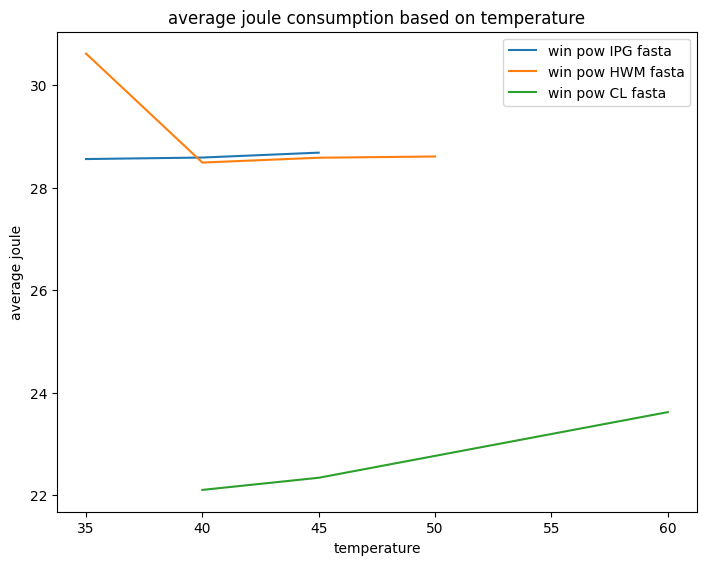

In [474]:
used_duts = [POWER_KOMPLETT]
used_test_cases = [FASTA]# test_cases

plot_iterations(CORE_TOTAL,
                get_buckets,
                is_correct_temperature,
                "temperature",
                "average joule",
                "average joule consumption based on temperature",
                data,
                dynamic_energy,
                used_duts=used_duts,
                used_test_cases=used_test_cases)

print("")

In [475]:
def is_correct_charge(exp, value):
    min_value = value[0]
    max_value = value[1]
    
    temp = [x.value for x in exp.start_battery.data]
    
    if len(temp) == 0:
        return False
    
    avg_temp = sum(temp) / len(temp)
    
    return avg_temp >= min_value and avg_temp < max_value

### Battery levels effect on energy consumption

A graph presenting the relationship between the battery level and energy consumption

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['Fasta']


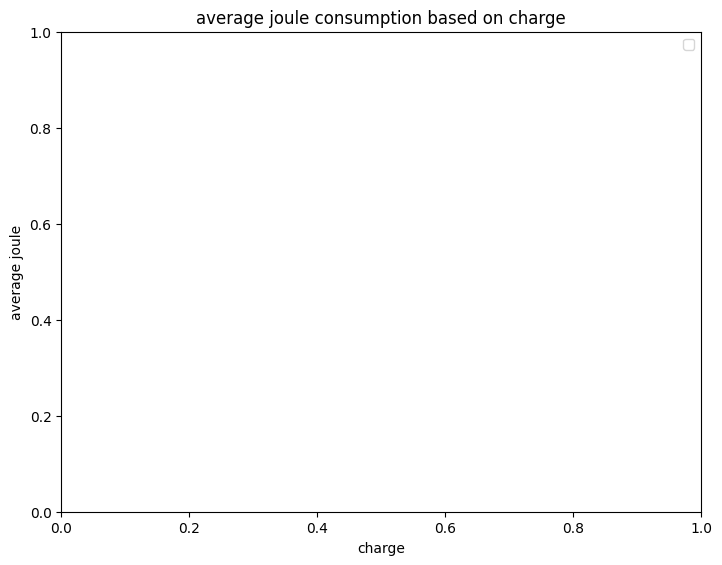

In [476]:
used_duts = [SURFACE_4_PRO]
used_test_cases = [FASTA] #test_cases

plot_iterations(CORE_TOTAL,
                get_buckets,
                is_correct_charge,
                "charge",
                "average joule",
                "average joule consumption based on charge",
                data,
                dynamic_energy,
                used_duts=used_duts,
                used_test_cases=used_test_cases)

print("")


In [477]:
# intel_power_gadget_data_point = data[SURFACE_4_PRO][WINDOWS_OS][BINARY_TREE][INTEL_POWER_GADGET]["experiment"].experiments[0].time_series.data_point[0]
# inspect.getmembers(intel_power_gadget_data_point, lambda a:not(inspect.isroutine(a)))

In [478]:
# intel_power_gadget_data_point.SystemTime, intel_power_gadget_data_point.CumulativeProcessorEnergy_0Joules

In [479]:
# hardware_monitor_data_point = data[SURFACE_4_PRO][LINUX_OS][BINARY_TREE][RAPL]["experiment"].experiments[0].time_series.data_point[:10]
# inspect.getmembers(hardware_monitor_data_point, lambda a:not(inspect.isroutine(a)))

In [480]:
# for i in [x for x in data[SURFACE_4_PRO][LINUX_OS][FANNKUCH_REDUX][RAPL]["experiment"].experiments[0].time_series.data_point[:10]]:
#     print(i.Core)
#     # print(i.CoreTotal)
#     print(i.PSys)
#     # print(i.PSysTotal)
#     print(i.PackageZero)
#     # print(i.PackageZeroTotal)
#     print("---")

In [481]:
# hardware_monitor_data_point.time, hardware_monitor_data_point.totalLoad

In [482]:
def plot_timestamp(timestamps, values):
    plt.plot(timestamps,values)
    plt.gcf().autofmt_xdate()
    plt.show()

In [487]:
data[POWER_KOMPLETT][WINDOWS_OS][BINARY_TREE][CLAMP]["experiment"].experiments[0].time_series.data_point[0]

In [488]:
def get_time(x, p):
    if p == INTEL_POWER_GADGET:
        return datetime.strptime(x.SystemTime, "%H:%M:%S:%f")
    elif p == HARDWARE_MONITOR:
        return datetime.strptime(trim_date(x.time), "%Y-%m-%d %H:%M:%S.%f")
    elif p == RAPL:
        return datetime.strptime(trim_date(x.Time), "%Y-%m-%d %H:%M:%S.%f")
    elif p == CLAMP:
        return datetime.strptime(trim_date(x.TimeStamp), "%Y-%m-%d-%H-%M-%S-%f")
    else:
        raise Exception(f"{p} not implemented")

def get_value(x, p):
    if p == INTEL_POWER_GADGET:
        return float(x.ProcessorPower_0Watt)
    elif p == HARDWARE_MONITOR:
        return float(x.cpuPowerPacket)
    elif p == RAPL:
        return float(x.PackageZero) * 10
    elif p == CLAMP:
        return float(x.C1TrueRMSPower) * 10
    else:
        raise Exception(f"{p} not implemented")

def trim_date(date):
    date = date.replace("T", " ")
    date = date.replace("Z", " ")
    return date[:-3]        

def plot_test_case_time_series(d, o, t, p, index=0):
    data_points = data[d][o][t][p]["experiment"].experiments[index].time_series.data_point

    timestamps = [get_time(x, p) for x in data_points]
    
    values = []
    last_value = -1
    
    for x in data_points:
        new_value = get_value(x, p)
        
        # if p == RAPL:
        #     if last_value == -1:
        #         last_value = new_value
            
        #     values.append(new_value - last_value)
            
        #     last_value = new_value
        # else:
        values.append(new_value)
        
    
    
    
    # values = [get_value(x, p) for x in data_points]

    plot_timestamp(timestamps, values)
    print(values[:10])

def get_values_for_time_series(d, o, t, p):
    data_point_dict = {}
    
    for exp in data[d][o][t][p]["experiment"].experiments:
        data_points = exp.time_series.data_point
        
        for i in range(len(data_points)):
            new_value = get_value(data_points[i], p)
            
            if not i in data_point_dict:
                data_point_dict[i] = []
            
            data_point_dict[i].append(new_value)
    
    return data_point_dict

In [489]:
# test_case = IDLE_CASE,
test_case = BINARY_TREE
# test_case = FANNKUCH_REDUX,
# test_case = NBODY
# test_case = FASTA

In [490]:
# plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, INTEL_POWER_GADGET, index=0)
# plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, INTEL_POWER_GADGET, index=1)
# plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, INTEL_POWER_GADGET, index=2)
# plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, INTEL_POWER_GADGET, index=3)
# plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, INTEL_POWER_GADGET, index=4)
# plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, INTEL_POWER_GADGET, index=5)
# plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, INTEL_POWER_GADGET, index=6)
# plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, INTEL_POWER_GADGET, index=7)

In [492]:
# plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, INTEL_POWER_GADGET)
# plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, HARDWARE_MONITOR)
# plot_test_case_time_series(SURFACE_4_PRO, LINUX_OS, test_case, RAPL)

In [493]:
# plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, INTEL_POWER_GADGET)
# plot_test_case_time_series(SURFACE_BOOK, WINDOWS_OS, test_case, INTEL_POWER_GADGET)
# plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, INTEL_POWER_GADGET)

In [494]:
# plot_test_case_time_series(SURFACE_4_PRO, WINDOWS_OS, test_case, HARDWARE_MONITOR)
# plot_test_case_time_series(SURFACE_BOOK, WINDOWS_OS, test_case, HARDWARE_MONITOR)
# plot_test_case_time_series(POWER_KOMPLETT, WINDOWS_OS, test_case, HARDWARE_MONITOR)

In [ ]:
for d in test_cases:
    for p in profilers:
        print(f"{p} - {d}")

IntelPowerGadget - TestCaseIdle
RAPL - TestCaseIdle
HardwareMonitor - TestCaseIdle
Clamp - TestCaseIdle
E3 - TestCaseIdle
IntelPowerGadget - BinaryTrees
RAPL - BinaryTrees
HardwareMonitor - BinaryTrees
Clamp - BinaryTrees
E3 - BinaryTrees
IntelPowerGadget - FannkuchRedux
RAPL - FannkuchRedux
HardwareMonitor - FannkuchRedux
Clamp - FannkuchRedux
E3 - FannkuchRedux
IntelPowerGadget - Nbody
RAPL - Nbody
HardwareMonitor - Nbody
Clamp - Nbody
E3 - Nbody
IntelPowerGadget - Fasta
RAPL - Fasta
HardwareMonitor - Fasta
Clamp - Fasta
E3 - Fasta


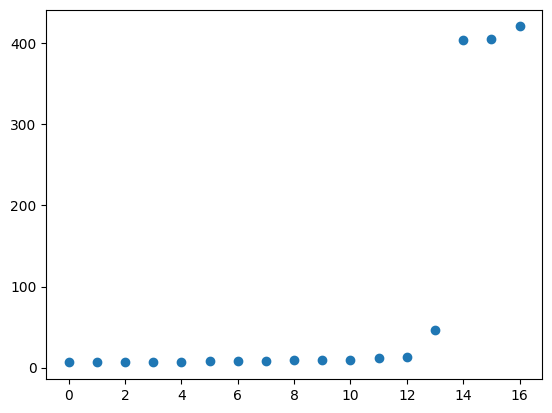

45.88319167674808


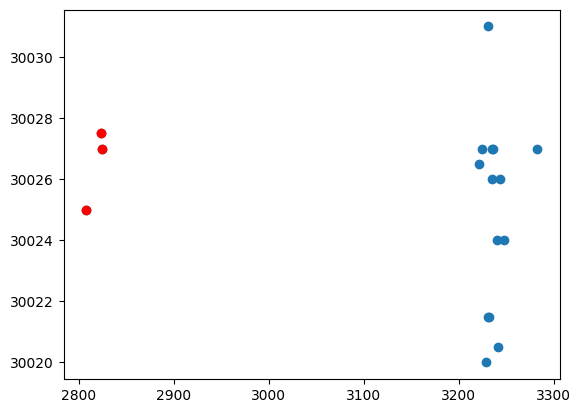

3 points were removed


[11635, 11674, 11629]

In [496]:
o_os = WINDOWS_OS
o_dut = POWER_KOMPLETT
o_test_case = IDLE_CASE
o_profiler = CLAMP
#  Win32NT - Surface4Pro - TestCaseIdle - IntelPowerGadget

y_max = 0.4
y_min = 0.2
x_min = 0
x_max = 0.1

use_x_lim = False
use_y_lim = False

# use_x_lim = False
# use_y_lim = False


experiments = data[o_dut][o_os][o_test_case][o_profiler]["experiment"].experiments
k = 4
look_back = 4

exp_ids_to_remove, point_a, point_b, point_c, point_d, point_e = find_outliers(experiments, k, look_back, o_profiler,y_max, y_min, x_min, x_max, use_x_lim, use_y_lim, show_graphs=True)

exp_ids_to_remove

In [ ]:
f"on {o_os} for dut {o_dut} {o_test_case} measured by {o_profiler}"

'on Win32NT for dut PowerKomplett Fasta measured by HardwareMonitor'

In [ ]:
# for (b_p, c_p) in zip(b_to_list, c_to_list):
#     print(f"        {b_p} {c_p} a")

# for (b_p, c_p) in zip(d_to_list, e_to_list):
#     print(f"        {b_p} {c_p} b")

In [ ]:
# for a in a_to_list:
#     print(f"        {a[0]} {a[1]} a")

In [497]:
# repository = DataRepository()

Connected to MySQL Server version  5.7.40-43-log


In [498]:
# version = dut_version[o_dut][o_os]
# parameters_for_query = (o_dut, o_os, o_test_case, version, o_profiler)
# parameters_for_insert = (k, look_back, o_dut, o_os, o_test_case, version, o_profiler)

# # repository.parameters_exists(parameters_for_query, repository)
# repository.insert_parameters(parameters_for_query, parameters_for_insert, repository)
# repository.get_parameters(parameters_for_query, repository)

update


(4, 4)

In [ ]:
# [
#     [[
#         ((get_is_correct_profiler_method(INTEL_POWER_GADGET, x), INTEL_POWER_GADGET), x), 
#         ((get_is_correct_profiler_method(HARDWARE_MONITOR, x), HARDWARE_MONITOR), x), 
#         ((get_is_correct_profiler_method(RAPL, x), RAPL), x), 
#         ((get_is_correct_profiler_method(CLAMP, x), CLAMP), x)] 
#     for x in [1, 3, 4, 5]]
# ][0][2]

In [ ]:
import os.path

def write_to_path(save_path, file_name, content):
    with open(os.path.join(save_path,file_name), "w") as file1:
        toFile = content
        file1.write(toFile)

In [ ]:
type_map = {
    DRAM_TOTAL : "Dram",
    CORE_TOTAL : "Cores"
}

In [ ]:
profiler_id_mapper = {
    1 : INTEL_POWER_GADGET,
    2 : E3,
    3 : HARDWARE_MONITOR,
    4 : RAPL,
    5 : CLAMP
}

In [533]:
def get_is_correct_profiler_method(first_profiler, profiler_id):
    
    def is_correct_exp(exp, value):
        return exp.first_profiler == first_profiler and exp.profiler_id == profiler_id
    
    return is_correct_exp

# p25s = []
# p75s = []
# low_whiskeys = []
# high_whiskeys = []
# medians = []
# names = []
# other_names = []

profiler_functions =  [
    [[
        (get_is_correct_profiler_method(INTEL_POWER_GADGET, x), INTEL_POWER_GADGET, x), 
        (get_is_correct_profiler_method(HARDWARE_MONITOR, x), HARDWARE_MONITOR, x), 
        (get_is_correct_profiler_method(RAPL, x), RAPL, x), 
        (get_is_correct_profiler_method(CLAMP, x), CLAMP, x)] 
    for x in [1, 3, 4, 5]]]

for measurement_type in [CORE_TOTAL, DRAM_TOTAL]:
    for is_dynamic in [True, False]:
        for include_outliers in [True, False]:
            for o in oses:
                for d in [POWER_KOMPLETT, SURFACE_4_PRO, SURFACE_BOOK]:
                    for profiler_func in profiler_functions[0]:
                        p25 = []
                        p75 = []
                        low_whiskey = []
                        high_whiskey = []
                        median = []
                        names = []
                        
                        desc = "dynamic energy" if is_dynamic else "energy"
                        desc_higg = "Dynamic Energy" if is_dynamic else "Energy"
                        desc_label = "dynamic_energy" if is_dynamic else "energy"
                        desc_outliers = "with outliers" if include_outliers else "without outliers"
                        desc_outliers_high = "With Outliers" if include_outliers else "Without Outliers"
                        desc_out_label = "with_outliers" if include_outliers else "without_outliers"
                        for t in test_cases:
                            for (pf, first_profiler, profiler_id) in profiler_func:
                                current_profiler = profiler_id_mapper[profiler_id]
                                
                                p25s, p75s, low_whiskeys, high_whiskeys, medians, _, _, _, namess = plot_comparison(
                                                CORE_TOTAL,
                                                data,
                                                dynamic_energy,
                                                f"",
                                                "",
                                                f"",
                                                get_dynamic=True,
                                                include_outliers=False,
                                                funcs=[(pf, first_profiler)],
                                                used_duts = [d],
                                                used_test_cases=[t],
                                                ylim_max=100,
                                                plot_graph=False,
                                                used_osses = [o]
                                                # used_profilers=[p]
                                                )
                                
                                p25.extend(p25s)
                                p75.extend(p75s)
                                low_whiskey.extend(low_whiskeys)
                                high_whiskey.extend(high_whiskeys)
                                median.extend(medians)
                                names.extend(namess)

                        plots = ""

                        for val in zip(low_whiskey, p25, median, p75, high_whiskey):
                            plots += """
                                    \\addplot+ [boxplot prepared={{
                                    lower whisker={0},
                                    lower quartile={1},
                                    median={2},
                                    upper quartile={3},
                                    upper whisker={4}}},
                                    ] table[row sep=\\\\,y index=0] {{\\\\}};
                                    """.format(val[0], val[1], val[2], val[3], val[4])

                        xlabel = f"Average {desc} (Watts)"
                        title = f"{'workstation' if d == POWER_KOMPLETT else d} - {current_profiler}"
                        ytick = str(list(range(1, len(p25)+1))).replace('[', '').replace(']', '')
                        yticklabels = str(names).replace('[', '').replace(']', '').replace('\'', '')
                        caption = f"R3 validation for {desc} measurements by {current_profiler} for the {type_map[measurement_type]} for all DUT's on {o} and test cases where the impact of the first profiler can be seen ({desc_outliers})"
                        # caption = f"R3 validation of {type_map[measurement_type]} ({desc}) when {} for test case {t} for all DUT's and OS's ({desc_outliers})"
                        label = f"{d}_{current_profiler}_{type_map[measurement_type]}_R3_{desc_label}_{desc_out_label}_{o}_avg_watts"
                        
                        if current_exp_name == "exp_two":
                            label = f"{label}_exp2"
                        
                        tex = """
                        \\begin{{figure}}
                            \\centering
                            \\begin{{tikzpicture}}[]
                                \pgfplotsset{{%
                                    width=.6\\textwidth,
                                    height=0.4\\textheight
                                }}
                                \\begin{{axis}}[xlabel={{{0}}}, title={{{1}}}, ytick={{{2}}},
                                yticklabels={{
                                    {3}
                                    }},
                                    xmin=0,xmax=80,
                                    ]
                                {4}
                                \\end{{axis}}
                            \\end{{tikzpicture}}
                        \\caption{{{5}}} \label{{fig:{6}}}
                        \\end{{figure}}
                        """

                        save_path = f"C:/Users/Mads Kusk/git/BiksPower/09th-semester-report/tabels/experiment_results/{current_exp_name}/R3/{desc_label}/{d}/{o}/{desc_out_label}/{type_map[measurement_type]}"
                        Path(save_path).mkdir(parents=True, exist_ok=True)
                        file_name = f"{current_profiler}.tex"
                        content = "succ"
                        write_to_path(save_path, file_name, tex.format(xlabel, title, ytick, yticklabels, plots, caption, label))

In [534]:

for is_dynamic in [True, False]:
    for include_outliers in [True, False]:
        for measurement_type in [CORE_TOTAL, DRAM_TOTAL]:
            for func_used in ["comparison"]:
                for t in test_cases:
                    used_test_cases = [t]
                    
                    desc = "dynamic energy consumption" if is_dynamic else "energy consumption"
                    desc_higg = "Dynamic Energy" if is_dynamic else "Energy"
                    desc_label = "dynamic_energy" if is_dynamic else "energy"
                    desc_outliers = "with outliers" if include_outliers else "without outliers"
                    desc_outliers_high = "With Outliers" if include_outliers else "Without Outliers"
                    desc_out_label = "with_outliers" if include_outliers else "without_outliers"
                    func_used_desc = "A comparison of" if func_used == "comparison" else "The impact of R3 validation for"
                    exp_lab = " for experiment \#2" if current_exp_name == "exp_two" else ""
                    
                    func_used_to_plot = default_func if func_used == "comparison" else is_correct_first_profiler

                    p25, p75, low_whiskey, high_whiskey, median, names, _, _, _ = plot_comparison(measurement_type, 
                                                                                            data, 
                                                                                            dynamic_energy, 
                                                                                            "", 
                                                                                            "", 
                                                                                            "", 
                                                                                            get_dynamic=is_dynamic, 
                                                                                            plot_graph=False, 
                                                                                            used_test_cases=used_test_cases, 
                                                                                            include_outliers=include_outliers,
                                                                                            include_idle = True)
                    
                    plots = ""

                    for val in zip(low_whiskey, p25, median, p75, high_whiskey):
                        plots += """
                                \\addplot+ [boxplot prepared={{
                                lower whisker={0},
                                lower quartile={1},
                                median={2},
                                upper quartile={3},
                                upper whisker={4}}},
                                ] table[row sep=\\\\,y index=0] {{\\\\}};
                                """.format(val[0], val[1], val[2], val[3], val[4])

                    xlabel = f"Average {desc} (Watts)"
                    title = f"{type_map[measurement_type]} - {t} - {desc_higg} - {desc_outliers}"
                    ytick = str(list(range(1, len(p25)+1))).replace('[', '').replace(']', '')
                    yticklabels = str(names).replace('[', '').replace(']', '').replace('\'', '')
                    caption = f"{func_used_desc} of {type_map[measurement_type]} {desc} for test case {t} for all DUT's and OS's {exp_lab} ({desc_outliers})"
                    label = f"{t}_{type_map[measurement_type]}_{func_used}_{desc_label}_{desc_out_label}_avg_watts" 
                    
                    
                    if current_exp_name == "exp_two":
                        label = f"{label}_exp2"
                        tex = """
                        \\begin{{figure}}
                            \\centering
                            \\begin{{tikzpicture}}[]
                                \pgfplotsset{{%
                                    width=.7\\textwidth,
                                    height=.15\\textheight
                                }}
                                \\begin{{axis}}[xlabel={{{0}}}, title={{{1}}}, ytick={{{2}}},
                                yticklabels={{
                                    {3}
                                    }},
                                    xmin=0,xmax=80,
                                    ]
                                {4}
                                \\end{{axis}}
                            \\end{{tikzpicture}}
                        \\caption{{{5}}} \label{{fig:{6}}}
                        \\end{{figure}}
                        """
                    else:
                        tex = """
                        \\begin{{figure}}
                            \\centering
                            \\begin{{tikzpicture}}[]
                                \pgfplotsset{{%
                                    width=.7\\textwidth,
                                    height=.4\\textheight
                                }}
                                \\begin{{axis}}[xlabel={{{0}}}, title={{{1}}}, ytick={{{2}}},
                                yticklabels={{
                                    {3}
                                    }},
                                    xmin=0,xmax=80,
                                    ]
                                {4}
                                \\end{{axis}}
                            \\end{{tikzpicture}}
                        \\caption{{{5}}} \label{{fig:{6}}}
                        \\end{{figure}}
                        """

                    

                    save_path = f"C:/Users/Mads Kusk/git/BiksPower/09th-semester-report/tabels/experiment_results/{current_exp_name}/{func_used}/{desc_label}/{desc_out_label}/{type_map[measurement_type]}"
                    Path(save_path).mkdir(parents=True, exist_ok=True)
                    file_name = f"{t}.tex"
                    write_to_path(save_path, file_name, tex.format(xlabel, title, ytick, yticklabels, plots, caption, label))

In [535]:

for d in [POWER_KOMPLETT, SURFACE_4_PRO, SURFACE_BOOK]:
    for is_dynamic in [True, False]:
        for include_outliers in [True, False]:
            for measurement_type in [CORE_TOTAL, DRAM_TOTAL]:
                for func_used in ["comparison"]:
                    for t in test_cases:
                        used_test_cases = [t]
                        
                        desc = "dynamic energy consumption" if is_dynamic else "energy consumption"
                        desc_higg = "Dynamic Energy" if is_dynamic else "Energy"
                        desc_label = "dynamic_energy" if is_dynamic else "energy"
                        desc_outliers = "with outliers" if include_outliers else "without outliers"
                        desc_outliers_high = "With Outliers" if include_outliers else "Without Outliers"
                        desc_out_label = "with_outliers" if include_outliers else "without_outliers"
                        func_used_desc = "A comparison of" if func_used == "comparison" else "The impact of R3 validation for"
                        dut_name = "workstation" if d == POWER_KOMPLETT else d
                        exp_lab = " experiment \#2" if current_exp_name == "exp_two" else ""
                        
                        
                        func_used_to_plot = default_func if func_used == "comparison" else is_correct_first_profiler

                        p25, p75, low_whiskey, high_whiskey, median, names, aaa, bbb, ccc = plot_comparison(measurement_type, 
                                                                                                data, 
                                                                                                dynamic_energy, 
                                                                                                "", 
                                                                                                "", 
                                                                                                "", 
                                                                                                get_dynamic=is_dynamic, 
                                                                                                plot_graph=False, 
                                                                                                used_test_cases=used_test_cases, 
                                                                                                include_outliers=include_outliers,
                                                                                                include_idle = True,
                                                                                                used_duts=[d])
                        
                        plots = ""

                        for val in zip(low_whiskey, p25, median, p75, high_whiskey):
                            plots += """
                                    \\addplot+ [boxplot prepared={{
                                    lower whisker={0},
                                    lower quartile={1},
                                    median={2},
                                    upper quartile={3},
                                    upper whisker={4}}},
                                    ] table[row sep=\\\\,y index=0] {{\\\\}};
                                    """.format(val[0], val[1], val[2], val[3], val[4])

                        xlabel = f"Average {desc} (Watts)"
                        title = f"{type_map[measurement_type]} - {t} - {desc_higg} - {desc_outliers}"
                        ytick = str(list(range(1, len(p25)+1))).replace('[', '').replace(']', '')
                        yticklabels = str([n.split(" - ")[1] for n in names]).replace('[', '').replace(']', '').replace('\'', '')
                        caption = f"{func_used_desc} of {type_map[measurement_type]} {desc} for test case {t} for the {dut_name}, {exp_lab} ({desc_outliers})"
                        label = f"{t}_{type_map[measurement_type]}_{func_used}_{desc_label}_{desc_out_label}_{d}_avg_watts" 
                        
                        if current_exp_name == "exp_two":
                            label = f"{label}_exp2"

                        if d == POWER_KOMPLETT and current_exp_name == "exp_two":
                            tex = """
                            \\begin{{figure}}
                                \\centering
                                \\begin{{tikzpicture}}[]
                                    \pgfplotsset{{%
                                        width=.7\\textwidth,
                                        height=.15\\textheight
                                    }}
                                    \\begin{{axis}}[xlabel={{{0}}}, title={{{1}}}, ytick={{{2}}},
                                    yticklabels={{
                                        {3}
                                        }},
                                        xmin=0,xmax=80,
                                        ]
                                    {4}
                                    \\end{{axis}}
                                \\end{{tikzpicture}}
                            \\caption{{{5}}} \label{{fig:{6}}}
                            \\end{{figure}}
                            """
                        if d == POWER_KOMPLETT:
                            tex = """
                            \\begin{{figure}}
                                \\centering
                                \\begin{{tikzpicture}}[]
                                    \pgfplotsset{{%
                                        width=.7\\textwidth,
                                        height=.2\\textheight
                                    }}
                                    \\begin{{axis}}[xlabel={{{0}}}, title={{{1}}}, ytick={{{2}}},
                                    yticklabels={{
                                        {3}
                                        }},
                                        xmin=0,xmax=80,
                                        ]
                                    {4}
                                    \\end{{axis}}
                                \\end{{tikzpicture}}
                            \\caption{{{5}}} \label{{fig:{6}}}
                            \\end{{figure}}
                            """
                        elif d == SURFACE_4_PRO:
                            tex = """
                            \\begin{{figure}}
                                \\centering
                                \\begin{{tikzpicture}}[]
                                    \pgfplotsset{{%
                                        width=.7\\textwidth,
                                        height=.15\\textheight
                                    }}
                                    \\begin{{axis}}[xlabel={{{0}}}, title={{{1}}}, ytick={{{2}}},
                                    yticklabels={{
                                        {3}
                                        }},
                                        xmin=0,xmax=20,
                                        ]
                                    {4}
                                    \\end{{axis}}
                                \\end{{tikzpicture}}
                            \\caption{{{5}}} \label{{fig:{6}}}
                            \\end{{figure}}
                            """
                        else:
                            tex = """
                            \\begin{{figure}}
                                \\centering
                                \\begin{{tikzpicture}}[]
                                    \pgfplotsset{{%
                                        width=.7\\textwidth,
                                        height=.15\\textheight
                                    }}
                                    \\begin{{axis}}[xlabel={{{0}}}, title={{{1}}}, ytick={{{2}}},
                                    yticklabels={{
                                        {3}
                                        }},
                                        xmin=0,xmax=10,
                                        ]
                                    {4}
                                    \\end{{axis}}
                                \\end{{tikzpicture}}
                            \\caption{{{5}}} \label{{fig:{6}}}
                            \\end{{figure}}
                            """
                        

                        save_path = f"C:/Users/Mads Kusk/git/BiksPower/09th-semester-report/tabels/experiment_results/{current_exp_name}/{func_used}/{d}/{desc_label}/{desc_out_label}/{type_map[measurement_type]}"
                        Path(save_path).mkdir(parents=True, exist_ok=True)
                        file_name = f"{t}.tex"
                        write_to_path(save_path, file_name, tex.format(xlabel, title, ytick, yticklabels, plots, caption, label))

In [536]:
# names[0].split(" - ")[1]

In [537]:
def plot_average_time_series(d, o, t, p, plot_graph = True):
    values_for_time_series = get_values_for_time_series(d, o, t, p)
    
    data_point_dict_min = {}
    data_point_dict_max = {}
    data_point_dict_avg = {}


    for k in values_for_time_series.keys():
        current_values = values_for_time_series[k]
        
        data_point_dict_min[k] = min(current_values)
        data_point_dict_max[k] = max(current_values)
        data_point_dict_avg[k] = sum(current_values) / len(current_values)
    
    min_data_points_to_plot = [(k, data_point_dict_min[k]) for k in data_point_dict_min.keys()]
    max_data_points_to_plot = [(k, data_point_dict_max[k]) for k in data_point_dict_max.keys()]
    avg_data_points_to_plot = [(k, data_point_dict_avg[k]) for k in data_point_dict_avg.keys()]
    
    if plot_graph:
        plt.plot(*zip(*min_data_points_to_plot))
        plt.plot(*zip(*max_data_points_to_plot))
        plt.plot(*zip(*avg_data_points_to_plot))
    
    return min_data_points_to_plot, max_data_points_to_plot, avg_data_points_to_plot

In [538]:
used_dut = POWER_KOMPLETT
used_os = WINDOWS_OS
used_test_case = FASTA
used_profiler = INTEL_POWER_GADGET

In [539]:
min_data_points_to_plot, max_data_points_to_plot, avg_data_points_to_plot = plot_average_time_series(used_dut, used_os, used_test_case, used_profiler, plot_graph = False)

In [540]:
len(min_data_points_to_plot), len(max_data_points_to_plot), len(avg_data_points_to_plot)

(601, 601, 601)

In [541]:
max_point_x = min_data_points_to_plot[-1][0]

for i in range(len(min_data_points_to_plot)):
    min_data_points_to_plot[i] = (((1/max_point_x) * i) * 60, min_data_points_to_plot[i][1])
    max_data_points_to_plot[i] = (((1/max_point_x) * i) * 60, max_data_points_to_plot[i][1])
    avg_data_points_to_plot[i] = (((1/max_point_x) * i) * 60, avg_data_points_to_plot[i][1])



In [542]:
min_data_points_to_plot[-1], max_data_points_to_plot[-1], avg_data_points_to_plot[-1]

((60.0, 50.921), (60.0, 59.468), (60.0, 54.761529411764705))

In [543]:
for d in duts:
    for o in oses:
        for t in test_cases:
            for p in profilers:
                used_dut = d
                used_os = o
                used_test_case = t
                used_profiler = p
                
                if data[d][o][t][p]["contains_data"]:
                    min_data_points_to_plot, max_data_points_to_plot, avg_data_points_to_plot = plot_average_time_series(used_dut, used_os, used_test_case, used_profiler, plot_graph = False)

                    max_point_x = min_data_points_to_plot[-1][0]

                    for i in range(len(min_data_points_to_plot)):
                        min_data_points_to_plot[i] = (((1/max_point_x) * i) * 60, min_data_points_to_plot[i][1])
                        max_data_points_to_plot[i] = (((1/max_point_x) * i) * 60, max_data_points_to_plot[i][1])
                        avg_data_points_to_plot[i] = (((1/max_point_x) * i) * 60, avg_data_points_to_plot[i][1])


                    exp_lab = "for experiment \#2," if current_exp_name == "exp_two" else ""
                    
                    x_label = "Time (Seconds)"
                    y_label = "Energy Consumption (Joules)" 
                    avg_values = str(avg_data_points_to_plot).replace("[", "").replace("]", "").replace("), (", ")(")
                    max_values = str(max_data_points_to_plot).replace("[", "").replace("]", "").replace("), (", ")(")
                    min_values = str(min_data_points_to_plot).replace("[", "").replace("]", "").replace("), (", ")(")
                    caption = f"The energy consumption {exp_lab} of test case {used_test_case} on {used_dut}, measured by {used_profiler}, with the lines representing the minimum, maximum and average energy consumption"
                    label = f"time_series_{used_test_case}_{used_dut}_{used_profiler}"
                    
                    if current_exp_name == "exp_two":
                        label = f"{label}_exp2"

                    tex = """
                    \\begin{{figure}}
                        \\centering
                        \\begin{{tikzpicture}}[]
                            \\begin{{axis}}[ymax=120,
                            xlabel={{{0}}},
                            ylabel={{{1}}},
                            ]
                            \\addplot[color=blue, mark=none,] coordinates {{ %% AVG value
                            {2}
                            }};
                            \\addplot[color=blue, mark=none,name path=A] coordinates {{ %% MAX value
                            {3}
                            }};
                            \\addplot[color=blue, mark=none,name path=B] coordinates {{ %% MIN value
                            {4}
                            }};
                            \\addplot [pattern=north east lines,pattern color=red] 
                            fill between [
                                of=A and B,soft clip={{domain=0:800}},
                            ];
                            \\end{{axis}}
                    \\end{{tikzpicture}}
                    \\caption{{{5}}} \label{{fig:{6}}}
                    \\end{{figure}}
                    """

                    save_path = f"C:/Users/Mads Kusk/git/BiksPower/09th-semester-report/tabels/experiment_results/{current_exp_name}/timeseries/{used_dut}/{used_os}/{used_profiler}"
                    Path(save_path).mkdir(parents=True, exist_ok=True)
                    file_name = f"{t}.tex"
                    content = "succ"
                    write_to_path(save_path, file_name, tex.format(x_label, y_label, avg_values, max_values, min_values, caption, label))

In [544]:
used_duts = duts
used_test_cases = [FASTA]



In [545]:
[x for x in duts]

['PowerKomplett']

In [546]:


line_colors = ["red", "green", "orange", "black", "pink", "blue"]
line_types = ["thick", "dotted", "dashed", "dashdotted"]

color_mapper = {
    INTEL_POWER_GADGET : "red",# "thick",
    HARDWARE_MONITOR : "blue",# "dotted",
    RAPL : "orange",# "dashed",
    E3 : "green",# "dashdotted",
    CLAMP : "black",# "dashdotdotted"
}

style_mapper = {
    SURFACE_4_PRO : "ultra thick", #"red",
    SURFACE_BOOK : "dashdotted", #"blue",
    "workstation" : "densely dashed", #"green"
}

In [547]:
exp_types = [("Runs since restart", "how long ago the DUT was restarted", "iteration", is_correct_iteration, get_iteration, "ymin=0,ymax=70,"),
            ("Start battery level", "the battey level of the DUT", "charge", is_correct_charge, get_buckets, "ymin=0,ymax=20,"),
            ("Start temperature", "the temperature of the DUT", "temperature", is_correct_temperature, get_buckets, "ymin=0,ymax=100,")]

for include_outliers in [True, False]:
    for exp_type in exp_types:
        current_label = exp_type[0] #"Runs since restart"
        current_desc = exp_type[1]#"how long ago the DUT was restarted"
        current_name = exp_type[2]#"iteration"
        current_is_correct = exp_type[3]# is_correct_iteration
        current_get = exp_type[4]#get_iteration
        current_min_max = exp_type[5]
        for measurement_type in [CORE_TOTAL, DRAM_TOTAL]:
            for t in test_cases:
                desc_outliers = "with outliers" if include_outliers else "without outliers"
                desc_outliers_high = "With Outliers" if include_outliers else "Without Outliers"
                desc_out_label = "with_outliers" if include_outliers else "without_outliers"
                
                used_test_cases = [t]
                x_lines, y_lines, name_lines = plot_iterations(measurement_type, 
                                                            current_get, 
                                                            current_is_correct, 
                                                            "",
                                                            "",
                                                            "",
                                                            data,
                                                            dynamic_energy,
                                                            used_test_cases = used_test_cases, 
                                                            plot_graph=False,
                                                            include_outliers=include_outliers
                                                        )
                
                plots = ""
                for z in zip(x_lines, y_lines,name_lines):
                    x = [(x[0], x[1]) for x in zip(z[0], z[1])]
                    
                    for d in duts:
                        if d in z[2]:
                            style = style_mapper[d]
                            break
                    for p in profilers:
                        if p in z[2]:
                            color = color_mapper[p]
                    
                    if "workstation" in z[2]:
                        style = "densely dashed"                
                    
                    if "(win)" in z[2]:
                        color = "cyan"

                    
                    plots += """
                            \\addplot [mark=none, {0}, {1}]  coordinates {{
                            {2}
                            }};
                            \\addlegendentry{{{3}}}
                            """.format(style, color, str(x).replace('[', '').replace(']', '').replace('), (', ')('), z[2])
                
                
                exp_lab = ", experiment \#2," if current_exp_name == "exp_two" else ""
                
                x_label = current_label
                y_label = "Average dynamic energy (watt)"
                caption = f"A graph illustrating the energy consumption of {type_map[measurement_type]} for test case {t} with regards to {current_desc}{exp_lab} ({desc_outliers})"
                label = f"{t}_{type_map[measurement_type]}_{current_name}"
                
                if current_exp_name == "exp_two":
                    label = f"{label}_exp2"

                tex = """
                \\begin{{figure}}
                    \\centering
                    \\begin{{tikzpicture}}
                        \\pgfplotsset{{%
                            width=1\\textwidth,
                            height=0.4\\textheight
                        }}
                        \\begin{{axis}}[
                            xlabel={{{0}}},
                            ylabel={{{1}}},
                            {2}
                        ]
                        {3}
                        \\end{{axis}}
                    \\end{{tikzpicture}} 
                \\caption{{{4}}} \label{{fig:{5}}}
                \\end{{figure}}
                """

                save_path = f"C:/Users/Mads Kusk/git/BiksPower/09th-semester-report/tabels/experiment_results/{current_exp_name}/graphs/{current_name}/{desc_out_label}/{type_map[measurement_type]}"
                Path(save_path).mkdir(parents=True, exist_ok=True)
                file_name = f"{t}.tex"
                write_to_path(save_path, file_name, tex.format(x_label, y_label, current_min_max, plots, caption, label))

['TestCaseIdle']
['BinaryTrees']
PowerKomplett - BinaryTrees - Win32NT - IntelPowerGadget - avg 3.0 (3, 3)
PowerKomplett - BinaryTrees - Win32NT - HardwareMonitor - avg 3.0 (3, 3)
PowerKomplett - BinaryTrees - Win32NT - Clamp - avg 3.0 (3, 3)
['FannkuchRedux']
PowerKomplett - FannkuchRedux - Win32NT - IntelPowerGadget - avg 3.0 (3, 3)
PowerKomplett - FannkuchRedux - Win32NT - HardwareMonitor - avg 3.0 (3, 3)
PowerKomplett - FannkuchRedux - Win32NT - Clamp - avg 3.0 (3, 3)
['Nbody']
PowerKomplett - Nbody - Win32NT - IntelPowerGadget - avg 3.0 (3, 3)
PowerKomplett - Nbody - Win32NT - HardwareMonitor - avg 3.0 (3, 3)
PowerKomplett - Nbody - Win32NT - Clamp - avg 3.0 (3, 3)
['Fasta']
PowerKomplett - Fasta - Win32NT - IntelPowerGadget - avg 3.4 (3, 4)
PowerKomplett - Fasta - Win32NT - HardwareMonitor - avg 40.0 (39, 41)
PowerKomplett - Fasta - Win32NT - Clamp - avg 3.6 (3, 4)
['TestCaseIdle']
['BinaryTrees']
PowerKomplett - BinaryTrees - Win32NT - IntelPowerGadget - avg 3.0 (3, 3)
PowerKomp

In [548]:
p25, p75, low_whiskey, high_whiskey, median, _, values, names, _ = plot_comparison(
    CORE_TOTAL, 
    data, 
    dynamic_energy, 
    "core total DUT", 
    "joules in a second", 
    "average core energy consumption in joules for DUTs", 
    ylim_max=100, 
    get_dynamic=False, 
    plot_graph=False, 
    include_idle=True,
    include_outliers=False 
    # used_profilers=[CLAMP]
    )

len(values[0]), len(values)

(16, 15)

In [549]:
results = []

# names = [""]
# values = [[26.62, 26.34, 26.34, 29.36, 26.33]]

for (v, n) in zip(values, names):
    # v = v[:2]
    # v = [round(x, 2) for x in v]
    # print(v)
    m = sum(v) / len(v)
    nom = 0
    
    for i in v:
        nom += (i - m) ** 2
    
    result = nom / len(v)
    
    results.append(result)
    # print(m)
    # print(result)
    
    
    # break
results

stds = [math.sqrt(x) for x in results]


Z = 1.96
E = 0.03

# Z = 2.58
# E = 0.01

n_zeros = []

for (n, s, v) in zip(names, stds, values):
    # v = v[:2]
    if not IDLE_CASE in n:
        n_zero = ((Z ** 2) * (s ** 2)) / (E ** 2)
        sample_size = ((Z ** 2) * s * (1-s)) / (E ** 2)
        n_zeros.append(n_zero)
        
        # print(f"n_0 = {n_zero}, {s}, {n}, {v}")
        # print(f"n_0 = {n_zero}, {s}, {n}, {min(v[:-1])}, {max(v[:-1])}")
        
        # if n_zero > 100:
        #     print("---")
        #     print(v)
        #     print("---")

max(n_zeros), len(n_zeros)



(0.05722848142094832, 12)